### In this notebook, Ive tried to implement a Deep Convolutional GAN or DCGAN from scratch by defining a Generator, a Discriminator and training them for maintaining the balance of universe :)

### [This](https://arxiv.org/pdf/1511.06434.pdf) paper is followed in the notebook for hyperparameter tuning and loss function maintainance.

### I've used cat images dataset to train the model. Hope you'll find it insightful

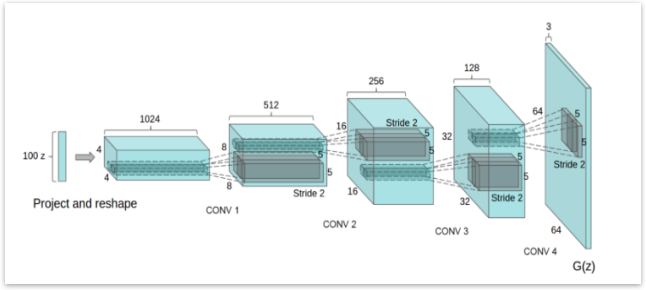

A dummy model for generator is shown here. Our model somewhat looks like this but is different in number of channels at some layers. The generator model is the most important part in the GAN as it originally generates the images. Sometimes, when GAN gets fully trained, the discriminator is frozen.

### Equation to be followed

min
G
max
D
V (D, G) = Ex∼pdata(x)
[log D(x)] + Ez∼pz(z)
[log(1 − D(G(z)))]

From Discriminator's perspective, we need to maximize the upper equation and from Generator's view, we train to minimized the second log term.
More literature and better understanding can be achieved by following [this](https://arxiv.org/pdf/1406.2661.pdf), the original GAN paper.

In [1]:
import numpy as np # linear algebra
import pandas as pd

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
direc= '../input/cats-faces-64x64-for-generative-models/'

In [5]:
print(os.listdir(direc+ '/cats')[:5])


['7981.jpg', '12666.jpg', '13288.jpg', '6234.jpg', '1269.jpg']


The data is normalized to mean=0 and SD= 0.5 so as to fit the data in (-1,1) range. This is useful for generator as it uses tanh function in the last layer. Apart from that, image size is reduced to 64x64 considering the computational cost. 

In [6]:
image_size = 64
batch_size = 128
latent_size= 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train = ImageFolder(direc, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))
 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True) #For loading data into batches

Generator intakes a s tensor of size N*(128x1x1) and outputs a (3x64x64) Tensor which inturn is an image. Since the GAN training are unstable as they start off with random noices, we require batchnormalization so the outputs remain normalized and under control.

In [7]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())
    # out: 3 x 64 x 64


Discriminator intakes the image outputs a tensor of size (1x1x1) providing a score between 0-1 according to the probability of real and fake.

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

A denorm function to denormalize the images produced by generator to make it understandable to human eyes.

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
#To save the samples produced during epochs

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors).to(device)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

### Function for training the discriminator

In [11]:
def train_discriminator(real_images, opt_d):
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images).to(device) #real images
    real_targets = torch.ones(real_images.size(0), 1).to(device) #setting targets as 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets) #getting the loss
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1).to(device) #generating the random noices for input image
    fake_images = generator(latent).to(device)  #getting the fake images

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1).to(device) #setting 0 as target for fake images
    fake_preds = discriminator(fake_images).to(device)  #getting the predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  #Comparing the two scores through loss
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Function for training the generator...Notice it doesnt require any input as it works with random noices.

In [12]:
def train_generator(opt_g):
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1).to(device) #random noice
    fake_images = generator(latent).to(device) #fake images generated
    
    # Try to fool the discriminator
    preds = discriminator(fake_images).to(device) #getting the predictions of discriminator for fake images
    targets = torch.ones(batch_size, 1).to(device) #setting 1 as targets so the discriminator can be fooled
    loss = F.binary_cross_entropy(preds, targets) #comparing
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item(),latent

In [13]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            # Train discriminator
            real_images= real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # Train generator
            loss_g, latent = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {}, loss_d: {}, real_score: {}, fake_score: {}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, latent, show=False)
    
    return losses_g, losses_d, latent, fake_scores

In [14]:
model = fit(epochs=10, lr=0.0002).to(device) #set epochs to 40 or more for better results

KeyboardInterrupt: 